In [1]:
import pandas as pd
import numpy as np
import phonenumbers
import pycountry_convert as pc
import configparser
import sqlite3 as sql


from phonenumbers.phonenumberutil import country_code_for_region
from datetime import datetime, date

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.naive_bayes import GaussianNB


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)


In [2]:
# Read data from datasource
def read_csv_file(file_path):
    try:
        # Attempt to read the CSV file
        data = pd.read_csv(file_path)
        print("File read successfully!")
        return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file contains parsing errors.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call read data func
file_path = '../data/HomeTask_ [1] User Information Labelled.csv'
labelled_user_info_df = read_csv_file(file_path)

if labelled_user_info_df is not None:
    print(labelled_user_info_df.shape)  # Display dataframe shape if data was successfully loaded


File read successfully!
(500, 16)


In [3]:
# Drop duplicate rows from 'labelled_user_info_df'
labelled_user_info_df = labelled_user_info_df.drop_duplicates()
print(labelled_user_info_df.shape)

(455, 16)


In [4]:
# Remove Missing data records
def remove_nan_rows(df, id_column):
    # Step 1: Remove rows with NaN values, but only if there are other rows with valid data for the same 'user_id'
    df_cleaned = df.dropna(subset=df.columns.difference([id_column]))
    
    # Step 2: Return the cleaned DataFrame
    return df_cleaned

# Call remove_nan_rows
cleaned_user_info_df = remove_nan_rows(labelled_user_info_df, 'user_id')
print(cleaned_user_info_df.shape)

(432, 16)


In [5]:
# Call read data func
file_path = '../data/HomeTask_ [2] Transaction Data Labelled.csv'
labelled_transaction_df = read_csv_file(file_path)

if labelled_transaction_df is not None:
    print(labelled_transaction_df.shape)  # Display shape of dataframe if data was successfully loaded

File read successfully!
(5945, 11)


In [6]:
# Merge both datasets on 'user_id'
df = pd.merge(cleaned_user_info_df, labelled_transaction_df, on='user_id')
df.shape

(6622, 26)

In [7]:
df.columns

Index(['user_id', 'session_id', 'country_of_residence', 'has_biometrics',
       'phone_number_country_code', 'reason_to_use_app', 'occupation',
       'kyc_state', 'gender', 'date_of_birth', 'document_issuing_country',
       'locale', 'screening_state', 'is_adverse_media_minor', 'is_pep',
       'user_current_state', 'id', 'reference_transaction_id', 'state', 'type',
       'category_id', 'amount', 'currency', 'direction', 'completed_at',
       'created_at'],
      dtype='object')

In [8]:
nan_control_cols = ['user_id', 'session_id', 'id', 'reference_transaction_id']
# Check for NaN values in the specified columns
def check_nan_in_columns(df, columns):
    # Iterate over the specified columns
    for col in columns:
        nan_count = df[col].isna().sum()  # Count NaN values in the column
        if nan_count > 0:
            print(f"Column '{col}' has {nan_count} NaN values.")
        else:
            print(f"Column '{col}' has no NaN values.")

# Example usage
# Assuming labelled_transaction_df is your DataFrame
check_nan_in_columns(df, nan_control_cols)


Column 'user_id' has no NaN values.
Column 'session_id' has no NaN values.
Column 'id' has no NaN values.
Column 'reference_transaction_id' has no NaN values.


In [9]:

# Method for reducing the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
df = reduce_mem_usage(df)


Mem. usage decreased to  1.10 Mb (7.0% reduction)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622 entries, 0 to 6621
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    6622 non-null   object 
 1   session_id                 6622 non-null   object 
 2   country_of_residence       6622 non-null   object 
 3   has_biometrics             6622 non-null   bool   
 4   phone_number_country_code  6622 non-null   int8   
 5   reason_to_use_app          6622 non-null   object 
 6   occupation                 6622 non-null   object 
 7   kyc_state                  6622 non-null   object 
 8   gender                     6622 non-null   object 
 9   date_of_birth              6622 non-null   object 
 10  document_issuing_country   6622 non-null   object 
 11  locale                     6622 non-null   object 
 12  screening_state            6622 non-null   object 
 13  is_adverse_media_minor     6622 non-null   bool 

In [12]:
df.iloc[:,14:].head()

,is_pep,user_current_state,id,reference_transaction_id,state,type,category_id,amount,currency,direction,completed_at,created_at
0,False,SUSPENDED,be097278-6ce9-4afe-84cc-96e24ed59e44,62fe1b69-52a9-4ae6-b13e-2d7932fc8d12,PENDING,PROCESSING_FEE,b818b29c-cd13-4352-863d-f930de135c65,14.992188,EUR,OUT,NaN,2024-08-04 15:26:52.418093 UTC
1,False,SUSPENDED,d0bb6764-6302-4444-94e9-0024302c2f90,e9ab418d-b2a7-46fe-8693-7d6c9110d1bb,COMPLETED,BANK_TRANSFER,e464e1e2-40ca-416d-a541-ba0865e252f9,5.000000,EUR,IN,2024-08-06 12:32:23.350767 UTC,2024-08-06 12:32:14.305982 UTC
2,False,SUSPENDED,ab000ca3-28b3-4610-8253-2b4f32d12da3,910b847b-c944-4cc6-8857-ba75d6befa46,DECLINED,CARDS,06bee557-499a-4d75-bc66-155ea0489a19,2.500000,EUR,OUT,2024-08-20 11:05:34.973154 UTC,2024-08-20 11:05:34.973154 UTC
3,False,SUSPENDED,dcc483c5-227e-4585-a874-6a0552ad771f,67859c37-b0e4-44b4-98b9-d53d66c97c42,COMPLETED,MANUAL,b818b29c-cd13-4352-863d-f930de135c65,25.015625,EUR,OUT,2024-08-20 08:22:31.556082 UTC,2024-08-20 08:22:31.556082 UTC
4,False,SUSPENDED,0aa0343d-4db8-4c93-b0ba-bc01e54befd8,03baa814-7bc3-4fdd-9f7f-580a5a76bf71,DECLINED,CARDS,8c6dc9fc-af02-4754-a312-25d7d05c091b,11.726562,EUR,OUT,2024-08-13 13:07:10.712891 UTC,2024-08-13 13:07:10.712891 UTC


In [13]:
df.currency.value_counts()

currency
EUR    6622
Name: count, dtype: int64

In [14]:
drop_cols = ['user_id', 'session_id', 'is_adverse_media_minor', 'is_pep', 'kyc_state', 'id',
             'reference_transaction_id', 'currency', 'completed_at', 'created_at', 'date_of_birth', 'continent_of_residence']
numeric_cols = ['amount', 'total_amount', 'average_amount', 'date_of_birth_days_since', 'process_time']
categoric_cols = ['country_of_residence', 'has_biometrics', 'phone_number_country_code', 'reason_to_use_app', 'occupation',
                  'kyc_state', 'gender', 'document_issuing_country', 'locale', 'screening_state', 'state', 'type', 'direction']
date_cols = ['date_of_birth', 'completed_at', 'created_at']

In [15]:
# Feature engineering - you can add new features like transaction frequency or total amount per user
df['transaction_count'] = df.groupby('user_id')['id'].transform('count')
df['total_amount'] = df.groupby('user_id')['amount'].transform('sum')
df['average_amount'] = df.groupby('user_id')['amount'].transform('mean')

In [16]:
# Method for filling the null values
def fill_null_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column].fillna('unknown', inplace=True)
        elif df[column].dtype in ['int64', 'float64']:
            df[column].fillna(0, inplace=True)
            df[column][np.isnan(df[column])] = 0
    return df

In [17]:
df = fill_null_values(df)

In [20]:
# Fucntion to calculate process time
def calculate_process_time(df, start_column, end_column):
    # Replace NaN values with 0 for both start and end times
    df[start_column] = pd.to_datetime(df[start_column], errors='coerce')  # Ensure it's a datetime
    df[end_column] = pd.to_datetime(df[end_column], errors='coerce')      # Ensure it's a datetime
    
    # Calculate the process time, set to 0 where either start or end is NaN
    df['process_time'] = (df[end_column] - df[start_column]).dt.total_seconds()
    
    # Where start or end time is NaN, set process_time to 0
    df['process_time'] = df['process_time'].fillna(0)
    
    return df

# Usage
df = calculate_process_time(df, 'created_at', 'completed_at')

# Display the DataFrame with the calculated process times
df.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,date_of_birth,...,category_id,amount,currency,direction,completed_at,created_at,transaction_count,total_amount,average_amount,process_time
0,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,b818b29c-cd13-4352-863d-f930de135c65,14.992188,EUR,OUT,NaT,2024-08-04 15:26:52.418093+00:00,11,139.226562,12.65696,0.000000
1,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,e464e1e2-40ca-416d-a541-ba0865e252f9,5.000000,EUR,IN,2024-08-06 12:32:23.350767+00:00,2024-08-06 12:32:14.305982+00:00,11,139.226562,12.65696,9.044785
2,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,06bee557-499a-4d75-bc66-155ea0489a19,2.500000,EUR,OUT,2024-08-20 11:05:34.973154+00:00,2024-08-20 11:05:34.973154+00:00,11,139.226562,12.65696,0.000000
3,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,b818b29c-cd13-4352-863d-f930de135c65,25.015625,EUR,OUT,2024-08-20 08:22:31.556082+00:00,2024-08-20 08:22:31.556082+00:00,11,139.226562,12.65696,0.000000
4,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,8c6dc9fc-af02-4754-a312-25d7d05c091b,11.726562,EUR,OUT,2024-08-13 13:07:10.712891+00:00,2024-08-13 13:07:10.712891+00:00,11,139.226562,12.65696,0.000000


In [21]:
scale_cols = ['amount', 'process_time', 'transaction_count']


# Function to apply Min-Max scaling to specific columns of a DataFrame
def normalize_data(dataframe, columns_to_scale):
    """
    This function applies Min-Max scaling to the specified columns of a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame with the data.
    columns_to_scale (list): A list of column names to be scaled.

    Returns:
    pd.DataFrame: The DataFrame with scaled columns.
    """

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler only to the specified columns
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

    return dataframe

df = normalize_data(df, scale_cols)

# Display the first few rows of the scaled dataframe
df.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,date_of_birth,...,category_id,amount,currency,direction,completed_at,created_at,transaction_count,total_amount,average_amount,process_time
0,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,b818b29c-cd13-4352-863d-f930de135c65,0.000375,EUR,OUT,NaT,2024-08-04 15:26:52.418093+00:00,0.011641,139.226562,12.65696,2.764266e-09
1,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,e464e1e2-40ca-416d-a541-ba0865e252f9,0.000125,EUR,IN,2024-08-06 12:32:23.350767+00:00,2024-08-06 12:32:14.305982+00:00,0.011641,139.226562,12.65696,3.238875e-06
2,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,06bee557-499a-4d75-bc66-155ea0489a19,0.000063,EUR,OUT,2024-08-20 11:05:34.973154+00:00,2024-08-20 11:05:34.973154+00:00,0.011641,139.226562,12.65696,2.764266e-09
3,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,b818b29c-cd13-4352-863d-f930de135c65,0.000625,EUR,OUT,2024-08-20 08:22:31.556082+00:00,2024-08-20 08:22:31.556082+00:00,0.011641,139.226562,12.65696,2.764266e-09
4,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,FR,True,33,TRAVEL_ACCOUNT,SERVICE_AND_SALES,COMPLETED,M,2002-03-09,...,8c6dc9fc-af02-4754-a312-25d7d05c091b,0.000293,EUR,OUT,2024-08-13 13:07:10.712891+00:00,2024-08-13 13:07:10.712891+00:00,0.011641,139.226562,12.65696,2.764266e-09


In [22]:
# Ensure 'total_amount' column is not using float16 by converting it to float64
df['total_amount'] = df['total_amount'].astype('float64')

# Create bins for 'total_amount'
total_amount_bins = [df['total_amount'].min(),
               1000,
               5000,
               df['total_amount'].mean(),
               df['total_amount'].mean() + df['total_amount'].std(),
               100000,
               df['total_amount'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(df['total_amount'], bins=total_amount_bins)

# Create groups with bins
data_set_size = df.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
             total_amount  count
0           (0.0, 1000.0]   1377
1        (1000.0, 5000.0]   1901
2     (5000.0, 14999.593]   1567
3  (14999.593, 43802.039]   1414
4   (43802.039, 100000.0]    246
5  (100000.0, 282938.594]    105


In [23]:
df['total_amount'] = pd.cut(df['total_amount'],
                      bins=total_amount_bins,
                      include_lowest=True,
                      duplicates='drop').cat.codes

In [24]:
# Ensure 'average_amount' column is not using float16 by converting it to float64
df['average_amount'] = df['average_amount'].astype('float64')

# Create bins for 'average_amount'
average_amount_bins = [df['average_amount'].min(),
               1,
               10,
               25,
               100,
               df['average_amount'].mean(),
               df['average_amount'].mean() + df['average_amount'].std(),
               5000,
               df['average_amount'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(df['average_amount'], bins=average_amount_bins)

# Create groups with bins
data_set_size = df.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
        average_amount  count
0           (0.0, 1.0]     23
1          (1.0, 10.0]    579
2         (10.0, 25.0]   1004
3        (25.0, 100.0]   3005
4     (100.0, 298.623]   1297
5  (298.623, 1409.668]    421
6   (1409.668, 5000.0]    192
7  (5000.0, 14301.143]     89


In [25]:
df['average_amount'] = pd.cut(df['average_amount'],
                      bins=average_amount_bins,
                      include_lowest=True,
                      duplicates='drop').cat.codes

In [26]:
df.iloc[:,15:].head()

,user_current_state,id,reference_transaction_id,state,type,category_id,amount,currency,direction,completed_at,created_at,transaction_count,total_amount,average_amount,process_time
0,SUSPENDED,be097278-6ce9-4afe-84cc-96e24ed59e44,62fe1b69-52a9-4ae6-b13e-2d7932fc8d12,PENDING,PROCESSING_FEE,b818b29c-cd13-4352-863d-f930de135c65,0.000375,EUR,OUT,NaT,2024-08-04 15:26:52.418093+00:00,0.011641,0,2,2.764266e-09
1,SUSPENDED,d0bb6764-6302-4444-94e9-0024302c2f90,e9ab418d-b2a7-46fe-8693-7d6c9110d1bb,COMPLETED,BANK_TRANSFER,e464e1e2-40ca-416d-a541-ba0865e252f9,0.000125,EUR,IN,2024-08-06 12:32:23.350767+00:00,2024-08-06 12:32:14.305982+00:00,0.011641,0,2,3.238875e-06
2,SUSPENDED,ab000ca3-28b3-4610-8253-2b4f32d12da3,910b847b-c944-4cc6-8857-ba75d6befa46,DECLINED,CARDS,06bee557-499a-4d75-bc66-155ea0489a19,0.000063,EUR,OUT,2024-08-20 11:05:34.973154+00:00,2024-08-20 11:05:34.973154+00:00,0.011641,0,2,2.764266e-09
3,SUSPENDED,dcc483c5-227e-4585-a874-6a0552ad771f,67859c37-b0e4-44b4-98b9-d53d66c97c42,COMPLETED,MANUAL,b818b29c-cd13-4352-863d-f930de135c65,0.000625,EUR,OUT,2024-08-20 08:22:31.556082+00:00,2024-08-20 08:22:31.556082+00:00,0.011641,0,2,2.764266e-09
4,SUSPENDED,0aa0343d-4db8-4c93-b0ba-bc01e54befd8,03baa814-7bc3-4fdd-9f7f-580a5a76bf71,DECLINED,CARDS,8c6dc9fc-af02-4754-a312-25d7d05c091b,0.000293,EUR,OUT,2024-08-13 13:07:10.712891+00:00,2024-08-13 13:07:10.712891+00:00,0.011641,0,2,2.764266e-09


In [27]:
location_cols = ['country_of_residence', 'phone_number_country_code', 'document_issuing_country', 'locale']
df[location_cols].head(10)

,country_of_residence,phone_number_country_code,document_issuing_country,locale
0,FR,33,FR,fr_FR
1,FR,33,FR,fr_FR
2,FR,33,FR,fr_FR
3,FR,33,FR,fr_FR
4,FR,33,FR,fr_FR
5,FR,33,FR,fr_FR
6,FR,33,FR,fr_FR
7,FR,33,FR,fr_FR
8,FR,33,FR,fr_FR
9,FR,33,FR,fr_FR


In [28]:
df['locale'] = df['locale'].str.split('_').str[1]
df['locale'] = df['locale'].replace('001', 'Global')


In [29]:
# Manual mapping of phone country codes to country abbreviations
country_code_to_abbr = {
    33: 'FR',  # France
    44: 'GB',  # United Kingdom
    1: 'US',   # United States/Canada
    39: 'IT',  # Italy
    34: 'ES',  # Spain
    68: 'Unknown',  # Undefined or not standard
    26: 'Unknown',  # Undefined or not standard
    59: 'Unknown',  # Undefined or not standard
    689: 'PF',  # French Polynesia
    687: 'NC',  # New Caledonia
    262: 'YT',  # Mayotte
    590: 'GP',  # Guadeloupe
    262: 'RE',  # Réunion
    351: 'PT',  # Portugal
    40: 'RO',  # Romania
}

# Function to convert country codes to country abbreviations
def convert_country_code_to_abbr(country_code):
    # Return the country abbreviation from the dictionary, or 'Unknown' if not found
    return country_code_to_abbr.get(country_code, 'Unknown')

In [30]:
# Apply the conversion function to the 'phone_number_country_code' and 'country_of_residence' columns
df['phone_number_country_code'] = df['phone_number_country_code'].apply(convert_country_code_to_abbr)
df[location_cols].head(10)

,country_of_residence,phone_number_country_code,document_issuing_country,locale
0,FR,FR,FR,FR
1,FR,FR,FR,FR
2,FR,FR,FR,FR
3,FR,FR,FR,FR
4,FR,FR,FR,FR
5,FR,FR,FR,FR
6,FR,FR,FR,FR
7,FR,FR,FR,FR
8,FR,FR,FR,FR
9,FR,FR,FR,FR


In [31]:
# Function to map country to continent and then to numeric values
def country_to_continent(country_abbr):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_abbr)
        continent_name = {
            'AF': 'Africa',
            'NA': 'North America',
            'SA': 'South America',
            'AS': 'Asia',
            'EU': 'Europe',
            'OC': 'Oceania',
            'AN': 'Antarctica',
            'Global' : 'Global'
        }
        return continent_name[continent_code]
    except KeyError:
        return 'Unknown'

In [32]:
# Function to convert continent names to numeric codes
def continent_to_numeric(continent):
    continent_map = {'Africa': 1, 'Asia': 2, 'Europe': 3, 'North America': 4, 'Oceania': 5, 
                     'South America': 6, 'Antarctica': 7, 'Global': 10, 'unknown': 100}
    
    return continent_map.get(continent, 9)

In [33]:
# Main function to process the DataFrame
def process_dataframe(df):
    # Keep 'country_of_residence'
    # The 'country_of_residence' column is already in the DataFrame
    
    # Find continents from 'country_of_residence' and convert continents to numeric values
    df['continent_of_residence'] = df['country_of_residence'].apply(country_to_continent)
    df['continent_code'] = df['continent_of_residence'].apply(continent_to_numeric)
    
    # Compare 'phone_number_country_code' with 'country_of_residence' and set 1 if they match, 0 otherwise
    df['phone_number_country_code'] = df.apply(lambda row: 1 if row['phone_number_country_code'] == row['country_of_residence'] else 0, axis=1)
    
    # Step 4: Compare 'document_issuing_country' with 'country_of_residence' and set 1 if they match, 0 otherwise
    df['document_issuing_country'] = df.apply(lambda row: 1 if row['document_issuing_country'] == row['country_of_residence'] else 0, axis=1)
    
    # Step 5: Compare 'locale' with 'country_of_residence' and set 1 if they match, 0 otherwise
    df['locale'] = df.apply(lambda row: 1 if row['locale'] == row['country_of_residence'] else 0, axis=1)
    
    return df

In [34]:
# Process the DataFrame
df = process_dataframe(df)
df[['country_of_residence',	'phone_number_country_code',	'document_issuing_country', 'locale', 'continent_code'	]].head(10)

,country_of_residence,phone_number_country_code,document_issuing_country,locale,continent_code
0,FR,1,1,1,3
1,FR,1,1,1,3
2,FR,1,1,1,3
3,FR,1,1,1,3
4,FR,1,1,1,3
5,FR,1,1,1,3
6,FR,1,1,1,3
7,FR,1,1,1,3
8,FR,1,1,1,3
9,FR,1,1,1,3


In [35]:
# Function to get dummies for specified categorical columns
def one_hot_encode(df, categoric_cols):
    """
    This function takes a DataFrame and a list of categorical columns,
    and returns the DataFrame with the specified columns one-hot encoded.
    """
    # Apply pd.get_dummies() to the specified categorical columns
    df_encoded = pd.get_dummies(df, columns=categoric_cols, drop_first=False)  # drop_first=False keeps all dummy columns
    
    return df_encoded


In [36]:
# Call one got encoding fucntion with df and dedicated features
df_2 = one_hot_encode(df, categoric_cols)

In [37]:
df_2.columns

Index(['user_id', 'session_id', 'date_of_birth', 'is_adverse_media_minor',
       'is_pep', 'user_current_state', 'id', 'reference_transaction_id',
       'category_id', 'amount', 'currency', 'completed_at', 'created_at',
       'transaction_count', 'total_amount', 'average_amount', 'process_time',
       'continent_of_residence', 'continent_code', 'country_of_residence_FR',
       'country_of_residence_GP', 'country_of_residence_NC',
       'country_of_residence_PF', 'country_of_residence_RE',
       'country_of_residence_YT', 'has_biometrics_False',
       'has_biometrics_True', 'phone_number_country_code_0',
       'phone_number_country_code_1', 'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_

In [38]:
df.shape, df_2.shape

((6622, 32), (6622, 76))

In [39]:
df_2.iloc[:,:20].head()

,user_id,session_id,date_of_birth,is_adverse_media_minor,is_pep,user_current_state,id,reference_transaction_id,category_id,amount,currency,completed_at,created_at,transaction_count,total_amount,average_amount,process_time,continent_of_residence,continent_code,country_of_residence_FR
0,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,2002-03-09,False,False,SUSPENDED,be097278-6ce9-4afe-84cc-96e24ed59e44,62fe1b69-52a9-4ae6-b13e-2d7932fc8d12,b818b29c-cd13-4352-863d-f930de135c65,0.000375,EUR,NaT,2024-08-04 15:26:52.418093+00:00,0.011641,0,2,2.764266e-09,Europe,3,True
1,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,2002-03-09,False,False,SUSPENDED,d0bb6764-6302-4444-94e9-0024302c2f90,e9ab418d-b2a7-46fe-8693-7d6c9110d1bb,e464e1e2-40ca-416d-a541-ba0865e252f9,0.000125,EUR,2024-08-06 12:32:23.350767+00:00,2024-08-06 12:32:14.305982+00:00,0.011641,0,2,3.238875e-06,Europe,3,True
2,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,2002-03-09,False,False,SUSPENDED,ab000ca3-28b3-4610-8253-2b4f32d12da3,910b847b-c944-4cc6-8857-ba75d6befa46,06bee557-499a-4d75-bc66-155ea0489a19,0.000063,EUR,2024-08-20 11:05:34.973154+00:00,2024-08-20 11:05:34.973154+00:00,0.011641,0,2,2.764266e-09,Europe,3,True
3,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,2002-03-09,False,False,SUSPENDED,dcc483c5-227e-4585-a874-6a0552ad771f,67859c37-b0e4-44b4-98b9-d53d66c97c42,b818b29c-cd13-4352-863d-f930de135c65,0.000625,EUR,2024-08-20 08:22:31.556082+00:00,2024-08-20 08:22:31.556082+00:00,0.011641,0,2,2.764266e-09,Europe,3,True
4,005256f3-53d4-471c-8bbd-b0c5e16bf2f7,882dd5b7-e378-4947-89e0-900a79b3083f,2002-03-09,False,False,SUSPENDED,0aa0343d-4db8-4c93-b0ba-bc01e54befd8,03baa814-7bc3-4fdd-9f7f-580a5a76bf71,8c6dc9fc-af02-4754-a312-25d7d05c091b,0.000293,EUR,2024-08-13 13:07:10.712891+00:00,2024-08-13 13:07:10.712891+00:00,0.011641,0,2,2.764266e-09,Europe,3,True


In [40]:
df_3 = df_2.drop(columns=drop_cols, errors='ignore')  # errors='ignore' ensures no error if column not found
df_3.shape, df_2.shape

((6622, 65), (6622, 76))

In [41]:
df_3.columns

Index(['user_current_state', 'category_id', 'amount', 'transaction_count',
       'total_amount', 'average_amount', 'process_time', 'continent_code',
       'country_of_residence_FR', 'country_of_residence_GP',
       'country_of_residence_NC', 'country_of_residence_PF',
       'country_of_residence_RE', 'country_of_residence_YT',
       'has_biometrics_False', 'has_biometrics_True',
       'phone_number_country_code_0', 'phone_number_country_code_1',
       'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'occupation_FOOD_PREP_AND_CLEANING', 'occupation_HEALTH',
       'occupation_IT_AND_COMMUNICATION',
       'occupation_LEGAL_SOCIAL_AND_CULTUR

In [42]:
df_3 = reduce_mem_usage(df_3)

Mem. usage decreased to  0.52 Mb (23.4% reduction)


In [43]:
# Method for ordering the data
def move_target_to_end(df, target_column):
    """
    Move the target column to the end of the DataFrame.

    Parameters:
    - df: pandas DataFrame
    - target_column: str, the name of the target column

    Returns:
    - df: pandas DataFrame, updated DataFrame
    """

    # Ensure the target column is in the DataFrame
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found in the DataFrame.")
        return df

    # Reorder columns to move the target column to the end
    new_order = [col for col in df.columns if col != target_column] + [target_column]
    df = df[new_order]

    return df
df_3 = move_target_to_end(df_3, 'user_current_state')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622 entries, 0 to 6621
Data columns (total 65 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   category_id                                      6622 non-null   object 
 1   amount                                           6622 non-null   float16
 2   transaction_count                                6622 non-null   float16
 3   total_amount                                     6622 non-null   int8   
 4   average_amount                                   6622 non-null   int8   
 5   process_time                                     6622 non-null   float16
 6   continent_code                                   6622 non-null   int8   
 7   country_of_residence_FR                          6622 non-null   bool   
 8   country_of_residence_GP                          6622 non-null   bool   
 9   country_of_residence_NC       

In [44]:
df_4 = df_3.drop(columns=['category_id'])  # features (independent variables)
df_4['user_current_state'] = df_4['user_current_state'].apply(lambda x: 1 if x == 'SUSPENDED' else 0)  # SUSPENDED=1, ACTIVE=0
df_4.columns

Index(['amount', 'transaction_count', 'total_amount', 'average_amount',
       'process_time', 'continent_code', 'country_of_residence_FR',
       'country_of_residence_GP', 'country_of_residence_NC',
       'country_of_residence_PF', 'country_of_residence_RE',
       'country_of_residence_YT', 'has_biometrics_False',
       'has_biometrics_True', 'phone_number_country_code_0',
       'phone_number_country_code_1', 'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'occupation_FOOD_PREP_AND_CLEANING', 'occupation_HEALTH',
       'occupation_IT_AND_COMMUNICATION',
       'occupation_LEGAL_SOCIAL_AND_CULTURAL_ACTIVITIES',
       'occupation_MANAGEMEN

In [45]:
%%time
# Calculating correlation
corr = df_4.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'user_current_state'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.05].sort_values(ascending=False)


len(best_accurate_columns)

CPU times: user 34.7 ms, sys: 1.54 ms, total: 36.2 ms
Wall time: 35.9 ms


39

In [46]:
best_accurate_columns.keys()

Index(['type_BANK_TRANSFER', 'occupation_PLANT_AND_MACHINE_OPERATION',
       'country_of_residence_FR', 'document_issuing_country_1',
       'occupation_MINING_CONSTRUCTION_AND_TRANSPORT', 'occupation_STUDENTS',
       'average_amount', 'direction_IN', 'state_COMPLETED',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS', 'occupation_MANAGEMENT',
       'reason_to_use_app_CRYPTO_SERVICES', 'occupation_EDUCATION',
       'total_amount', 'amount', 'locale_1', 'type_CRYPTO_ON_RAMP',
       'phone_number_country_code_1', 'phone_number_country_code_0',
       'reason_to_use_app_TRAVEL_ACCOUNT',
       'occupation_AGRICULTURE_FISHERY_FORESTRY', 'continent_code', 'locale_0',
       'country_of_residence_NC',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES', 'country_of_residence_RE',
       'state_DECLINED', 'state_PENDING', 'occupation_UNEMPLOYED',
       'country_of_residence_YT', 'occupation_HEALTH',
       'occupation_OTHER_SERVICE

In [47]:
# Function to write a list of values to config.ini
def write_to_config(section, option, values, config_file='../config.ini'):
    """
    Writes a list of values under a specified section and option in config.ini.
    
    Parameters:
    - section: The section name in the config file (e.g., 'params').
    - option: The option/key name (e.g., 'corr_cols').
    - values: A list of values to write (e.g., list of column names).
    - config_file: The path to the config file.
    """
    # Initialize the configparser
    config = configparser.ConfigParser()

    # Read the existing config file (if it exists)
    config.read(config_file)

    # Join the values as a comma-separated string
    values_str = ','.join(values)

    # Add the section if it doesn't exist
    if section not in config:
        config[section] = {}

    # Set the option under the section
    config[section][option] = values_str

    # Write the configuration to a file
    with open(config_file, 'w') as configfile:
        config.write(configfile)

# Example usage:
write_to_config('params', 'corr_cols', best_accurate_columns.keys())


In [48]:
df_4.head()

,amount,transaction_count,total_amount,average_amount,process_time,continent_code,country_of_residence_FR,country_of_residence_GP,country_of_residence_NC,country_of_residence_PF,...,type_CARD_TOP_UP,type_CRYPTO_OFF_RAMP,type_CRYPTO_ON_RAMP,type_MANUAL,type_PAYMENTS,type_PROCESSING_FEE,type_USER_REWARD,direction_IN,direction_OUT,user_current_state
0,0.000375,0.011642,0,2,0.000000,3,True,False,False,False,...,False,False,False,False,False,True,False,False,True,1
1,0.000125,0.011642,0,2,0.000003,3,True,False,False,False,...,False,False,False,False,False,False,False,True,False,1
2,0.000063,0.011642,0,2,0.000000,3,True,False,False,False,...,False,False,False,False,False,False,False,False,True,1
3,0.000626,0.011642,0,2,0.000000,3,True,False,False,False,...,False,False,False,True,False,False,False,False,True,1
4,0.000293,0.011642,0,2,0.000000,3,True,False,False,False,...,False,False,False,False,False,False,False,False,True,1


In [49]:
X = df_4[best_accurate_columns.keys()].copy()
y = df_4['user_current_state'].copy()
X.shape, y.shape

((6622, 39), (6622,))

In [50]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5297, 39), (1325, 39), (5297,), (1325,))

## **Model Training**

## RandomForestClassifier


In [51]:
# Defining hyperparameter values for the Random Forest Classifier

n_estimators = [150, 250, 350]            # Number of trees in the forest (using 700 trees)
max_depth = [40, 35, 30, 25, 20]             # Maximum depth of each tree (testing depths of 10 and 8)
min_samples_split = [5, 3, 2]     # Minimum number of samples required to split an internal node (testing values 10 and 5)
min_samples_leaf = [5, 3, 2]       # Minimum number of samples required to be a leaf node (testing values 5 and 3)

# Creating a dictionary that stores these hyperparameter options
hyper_random = {
    "n_estimators": n_estimators,              # Number of trees to be used
    "max_depth": max_depth,                    # Maximum tree depths to be used
    "min_samples_split": min_samples_split,    # Minimum samples required for splitting a node
    "min_samples_leaf": min_samples_leaf       # Minimum samples required for a leaf node
}


In [52]:
%%time
# Perform Grid Search to find the best hyperparameters for Random Forest Classifier

clf_rf_tuned = GridSearchCV(RandomForestClassifier(),   # The model being tuned is a Random Forest Classifier
                            hyper_random,               # The hyperparameter grid defined earlier
                            cv=5,                       # 5-fold cross-validation
                            verbose=1,                  # Verbosity level (1 = prints progress)
                            n_jobs=-1)                  # Use all available CPU cores to parallelize the work

# Fit the model on the training data
clf_rf_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
CPU times: user 1.28 s, sys: 346 ms, total: 1.62 s
Wall time: 41.9 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 35, 30, 25, 20],
                         'min_samples_leaf': [5, 3, 2],
                         'min_samples_split': [5, 3, 2],
                         'n_estimators': [150, 250, 350]},
             verbose=1)

In [53]:

best_params_random = clf_rf_tuned.best_params_
print(best_params_random)

{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [54]:
# Parameter settings
CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])

In [55]:
# Fit the model (CV_clf_rf) on the training data
CV_clf_rf.fit(X_train, y_train)

# Predict the probabilities for the test data (specifically the probability of class 1)
y_test_predict_random = CV_clf_rf.predict_proba(X_test)[:, 1]

# Predict the class labels for the test data
yhat_random = CV_clf_rf.predict(X_test)

# Compute the calibration curve (fraction of positives vs. mean predicted value)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                y_test_predict_random,
                                                                n_bins=10)

In [56]:
# Print the classification report of the model's predictions on the test data
print(classification_report(y_test, yhat_random))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       943
           1       0.92      0.93      0.93       382

    accuracy                           0.96      1325
   macro avg       0.95      0.95      0.95      1325
weighted avg       0.96      0.96      0.96      1325



In [57]:
result_df = X_test.copy()
result_df['user_current_state'] = y_test
result_df['rf_pred'] = yhat_random
result_df.head()

,type_BANK_TRANSFER,occupation_PLANT_AND_MACHINE_OPERATION,country_of_residence_FR,document_issuing_country_1,occupation_MINING_CONSTRUCTION_AND_TRANSPORT,occupation_STUDENTS,average_amount,direction_IN,state_COMPLETED,reason_to_use_app_INTERNATIONAL_TRANSFERS,...,occupation_HEALTH,occupation_OTHER_SERVICES,occupation_SERVICE_AND_SALES,direction_OUT,country_of_residence_PF,type_CARDS,document_issuing_country_0,transaction_count,user_current_state,rf_pred
96,False,False,True,True,False,False,3,True,False,False,...,False,True,False,False,False,False,False,0.156006,0,0
994,False,False,False,False,False,False,1,False,True,True,...,False,False,True,True,False,True,True,0.010475,0,0
1400,True,False,True,True,False,True,1,True,True,False,...,False,False,False,False,False,False,False,0.229370,1,1
865,False,False,False,False,False,False,3,False,False,False,...,False,False,False,True,False,True,True,0.100098,0,0
6097,False,False,True,False,False,False,3,False,True,False,...,False,True,False,True,False,False,True,0.123413,0,0


In [58]:
# Print the shape of the result_df dataset
print("Dataset shape = ", result_df.shape[0])

# For Random Forest predictions
print("For Random Forest :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Random Forest
print("Total negative case = ", result_df[result_df.user_current_state == 0].shape[0])
print("Correct : ",result_df[(result_df.user_current_state == 0) & (result_df.rf_pred == 0)].shape[0])

# Count of False Positives: instances where actual label is 0 but predicted as 1 by Random Forest
print("False : ",result_df[(result_df.user_current_state == 0) & (result_df.rf_pred == 1)].shape[0])

print("Total positive case = ", result_df[result_df.user_current_state == 1].shape[0])

# Count of True Positives: instances where actual label is 1 and predicted as 1 by Random Forest
print("Correct : ",result_df[(result_df.user_current_state == 1) & (result_df.rf_pred == 1)].shape[0])

# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Random Forest
print("False : ",result_df[(result_df.user_current_state == 1) & (result_df.rf_pred == 0)].shape[0])


Dataset shape =  1325
For Random Forest :
Total negative case =  943
Correct :  914
False :  29
Total positive case =  382
Correct :  356
False :  26


## GaussianNaiveBias


In [59]:
%%time

#Uncalibrated Gaussian Naive Bayes classifier
clf_nb = GaussianNB()  # Initialize a Gaussian Naive Bayes classifier
clf_nb.fit(X_train, y_train)  # Train the model on the training data

y_test_predict_nb = clf_nb.predict_proba(X_test)[:, 1]  # Get probability predictions for the test set
yhat_nb = clf_nb.predict(X_test)  # Get class predictions for the test set

fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_nb, n_bins=10)



# Calibrated  with isotonic NB
clf_sigmoid_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')  # Initialize isotonic calibration
clf_sigmoid_nb.fit(X_train, y_train)  # Calibrate the classifier using 10-fold cross-validation

y_test_predict_nb_calib = clf_sigmoid_nb.predict_proba(X_test)[:, 1]  # Get calibrated probability predictions
yhat_calibrated_nb = clf_sigmoid_nb.predict(X_test)  # Get calibrated class predictions

fraction_of_positives_nb_calib, mean_predicted_value_nb_calib = calibration_curve(y_test, y_test_predict_nb_calib, n_bins=10)

CPU times: user 158 ms, sys: 4.98 ms, total: 163 ms
Wall time: 166 ms


In [60]:
print(classification_report(y_test, yhat_nb))


              precision    recall  f1-score   support

           0       0.98      0.45      0.61       943
           1       0.42      0.98      0.58       382

    accuracy                           0.60      1325
   macro avg       0.70      0.71      0.60      1325
weighted avg       0.82      0.60      0.60      1325



In [61]:
print(classification_report(y_test, yhat_calibrated_nb))


              precision    recall  f1-score   support

           0       0.83      0.93      0.87       943
           1       0.75      0.51      0.61       382

    accuracy                           0.81      1325
   macro avg       0.79      0.72      0.74      1325
weighted avg       0.80      0.81      0.80      1325



In [62]:

result_df['Naive_Bias_Pred'] = yhat_nb
result_df['Isotonic_Calibrated_Naive_Bias_Pred'] = yhat_calibrated_nb

result_df.head()

,type_BANK_TRANSFER,occupation_PLANT_AND_MACHINE_OPERATION,country_of_residence_FR,document_issuing_country_1,occupation_MINING_CONSTRUCTION_AND_TRANSPORT,occupation_STUDENTS,average_amount,direction_IN,state_COMPLETED,reason_to_use_app_INTERNATIONAL_TRANSFERS,...,occupation_SERVICE_AND_SALES,direction_OUT,country_of_residence_PF,type_CARDS,document_issuing_country_0,transaction_count,user_current_state,rf_pred,Naive_Bias_Pred,Isotonic_Calibrated_Naive_Bias_Pred
96,False,False,True,True,False,False,3,True,False,False,...,False,False,False,False,False,0.156006,0,0,1,0
994,False,False,False,False,False,False,1,False,True,True,...,True,True,False,True,True,0.010475,0,0,0,0
1400,True,False,True,True,False,True,1,True,True,False,...,False,False,False,False,False,0.229370,1,1,1,1
865,False,False,False,False,False,False,3,False,False,False,...,False,True,False,True,True,0.100098,0,0,0,0
6097,False,False,True,False,False,False,3,False,True,False,...,False,True,False,False,True,0.123413,0,0,0,0


In [63]:
# Print the shape of the result_df dataset
print("Dataset shape = ", result_df.shape[0])

# For Naive Bias predictions
print("For Naive Bias :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Naive Bias
print("Total negative case = ", result_df[result_df.user_current_state == 0].shape[0])
print("Correct : ",result_df[(result_df.user_current_state == 0) & (result_df.Naive_Bias_Pred == 0)].shape[0])

# Count of False Positives: instances where actual label is 0 but predicted as 1 by Naive Bias
print("False : ",result_df[(result_df.user_current_state == 0) & (result_df.Naive_Bias_Pred == 1)].shape[0])

print("Total positive case = ", result_df[result_df.user_current_state == 1].shape[0])

# Count of True Positives: instances where actual label is 1 and predicted as 1 by Naive Bias
print("Correct : ",result_df[(result_df.user_current_state == 1) & (result_df.Naive_Bias_Pred == 1)].shape[0])

# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Naive Bias
print("False : ",result_df[(result_df.user_current_state == 1) & (result_df.Naive_Bias_Pred == 0)].shape[0])


Dataset shape =  1325
For Naive Bias :
Total negative case =  943
Correct :  420
False :  523
Total positive case =  382
Correct :  373
False :  9


In [64]:
# Print the shape of the result_df dataset
print("Dataset shape = ", result_df.shape[0])

# For Calibrated Naive Bias predictions
print("For Calibrated Naive Bias :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Calibrated Naive Bias
print("Total negative case = ", result_df[result_df.user_current_state == 0].shape[0])
print("Correct : ",result_df[(result_df.user_current_state == 0) & (result_df.Isotonic_Calibrated_Naive_Bias_Pred == 0)].shape[0])

# Count of False Positives: instances where actual label is 0 but predicted as 1 by Calibrated Naive Bias
print("False : ",result_df[(result_df.user_current_state == 0) & (result_df.Isotonic_Calibrated_Naive_Bias_Pred == 1)].shape[0])

print("Total positive case = ", result_df[result_df.user_current_state == 1].shape[0])

# Count of True Positives: instances where actual label is 1 and predicted as 1 by Calibrated Naive Bias
print("Correct : ",result_df[(result_df.user_current_state == 1) & (result_df.Isotonic_Calibrated_Naive_Bias_Pred == 1)].shape[0])

# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Calibrated Naive Bias
print("False : ",result_df[(result_df.user_current_state == 1) & (result_df.Isotonic_Calibrated_Naive_Bias_Pred == 0)].shape[0])

Dataset shape =  1325
For Calibrated Naive Bias :
Total negative case =  943
Correct :  877
False :  66
Total positive case =  382
Correct :  196
False :  186


## Apply the Model to Unlabeled Data

In [65]:
# Call read data func
file_path = '../data/HomeTask _ [3] User Information Unlabelled.csv'
unlabelled_user_info_df = read_csv_file(file_path)

if unlabelled_user_info_df is not None:
    print(unlabelled_user_info_df.shape)  # Display dataframe shape if data was successfully loaded

File read successfully!
(300, 14)


In [66]:
# Drop duplicate rows from 'labelled_user_info_df'
unlabelled_user_info_df = unlabelled_user_info_df.drop_duplicates()
print(unlabelled_user_info_df.shape)

(282, 14)


In [67]:
# Call remove_nan_rows
unlabelled_cleaned_user_info_df = remove_nan_rows(unlabelled_user_info_df, 'user_id')
print(unlabelled_cleaned_user_info_df.shape)

(248, 14)


In [68]:
# Call read data func
file_path = '../data/HomeTask _ [4] TransactionData Unlabelled.csv'
unlabelled_transaction_df = read_csv_file(file_path)

if unlabelled_transaction_df is not None:
    print(unlabelled_transaction_df.shape)  # Display shape of dataframe if data was successfully loaded

File read successfully!
(9849, 10)


In [69]:
# Merge both datasets on 'user_id'
df_test = pd.merge(unlabelled_cleaned_user_info_df, unlabelled_transaction_df, on='user_id')
results_df = df_test.copy()
df_test.shape

(7611, 23)

In [72]:
df_test.iloc[:,:15].head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,locale,screening_state,is_adverse_media_minor,is_pep,id
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,83a83d0f-35e2-4ce4-b1c2-3a233e7f08c4
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,0255aced-f1fc-4127-a764-4de91d373036
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,61a7c426-3a02-495e-a96f-e7cf3376206b
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,fr_BR,TO_SOFT_REVIEW,False,False,9fb2be9c-2b1f-4381-9263-ce125955ef34
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,fr_BR,TO_SOFT_REVIEW,False,False,94c1a135-6723-4496-8139-eff77c03c3e8


In [74]:
# Assuming df_test is your DataFrame
check_nan_in_columns(df_test, nan_control_cols)

Column 'user_id' has no NaN values.
Column 'session_id' has no NaN values.
Column 'id' has no NaN values.
Column 'reference_transaction_id' has no NaN values.


In [75]:
df_test = reduce_mem_usage(df_test)


Mem. usage decreased to  1.09 Mb (8.0% reduction)


In [76]:
# Feature engineering - you can add new features like transaction frequency or total amount per user
df_test['transaction_count'] = df_test.groupby('user_id')['id'].transform('count')
df_test['total_amount'] = df_test.groupby('user_id')['amount'].transform('sum')
df_test['average_amount'] = df_test.groupby('user_id')['amount'].transform('mean')

In [77]:
df_test = fill_null_values(df_test)

In [78]:
# Calculate process time
df_test = calculate_process_time(df_test, 'created_at', 'completed_at')

# Display the DataFrame with the calculated process times
df_test.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,...,type,amount,currency,direction,completed_at,created_at,transaction_count,total_amount,average_amount,process_time
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,PROCESSING_FEE,14.992188,EUR,OUT,NaT,2024-09-17 18:38:52.525988+00:00,3,229.992188,76.664062,0.000000
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,CARD_TOP_UP,110.000000,EUR,IN,2024-09-18 13:51:43.934669+00:00,2024-09-18 13:49:13.184326+00:00,3,229.992188,76.664062,150.750343
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,CARD_TOP_UP,105.000000,EUR,IN,2024-09-18 13:53:07.991475+00:00,2024-09-18 13:53:04.232099+00:00,3,229.992188,76.664062,3.759376
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,CARDS,13.796875,EUR,OUT,NaT,2024-08-25 11:32:11.370121+00:00,96,3568.051758,37.167206,0.000000
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,CARDS,9.929688,EUR,OUT,2024-08-25 06:20:22.529250+00:00,2024-08-24 10:10:51.551907+00:00,96,3568.051758,37.167206,72570.977343


In [79]:
df_test = normalize_data(df_test, scale_cols)

# Display the first few rows of the scaled dataframe
df_test.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,...,type,amount,currency,direction,completed_at,created_at,transaction_count,total_amount,average_amount,process_time
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,PROCESSING_FEE,0.000833,EUR,OUT,NaT,2024-09-17 18:38:52.525988+00:00,0.003584,229.992188,76.664062,1.304011e-09
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,CARD_TOP_UP,0.006111,EUR,IN,2024-09-18 13:51:43.934669+00:00,2024-09-18 13:49:13.184326+00:00,0.003584,229.992188,76.664062,3.716902e-05
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,CARD_TOP_UP,0.005833,EUR,IN,2024-09-18 13:53:07.991475+00:00,2024-09-18 13:53:04.232099+00:00,0.003584,229.992188,76.664062,9.281835e-07
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,CARDS,0.000766,EUR,OUT,NaT,2024-08-25 11:32:11.370121+00:00,0.170251,3568.051758,37.167206,1.304011e-09
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,CARDS,0.000552,EUR,OUT,2024-08-25 06:20:22.529250+00:00,2024-08-24 10:10:51.551907+00:00,0.170251,3568.051758,37.167206,1.789248e-02


In [80]:
# total_amount_bins and average_amount_bins
df_test['total_amount'] = pd.cut(df_test['total_amount'],
                      bins=total_amount_bins,
                      include_lowest=True,
                      duplicates='drop').cat.codes

df_test['average_amount'] = pd.cut(df_test['average_amount'],
                      bins=average_amount_bins,
                      include_lowest=True,
                      duplicates='drop').cat.codes

In [81]:
df_test['locale'] = df_test['locale'].str.split('_').str[1]
df_test['locale'] = df_test['locale'].replace('001', 'Global')

In [82]:
# Apply the conversion function to the 'phone_number_country_code' and 'country_of_residence' columns
df_test['phone_number_country_code'] = df_test['phone_number_country_code'].apply(convert_country_code_to_abbr)
df_test[location_cols].head(10)

,country_of_residence,phone_number_country_code,document_issuing_country,locale
0,FR,FR,FR,FR
1,FR,FR,FR,FR
2,FR,FR,FR,FR
3,FR,FR,IT,BR
4,FR,FR,IT,BR
5,FR,FR,IT,BR
6,FR,FR,IT,BR
7,FR,FR,IT,BR
8,FR,FR,IT,BR
9,FR,FR,IT,BR


In [83]:
# Process the DataFrame
df_test = process_dataframe(df_test)
df_test[['country_of_residence',	'phone_number_country_code',	'document_issuing_country', 'locale', 'continent_code'	]].head(10)

,country_of_residence,phone_number_country_code,document_issuing_country,locale,continent_code
0,FR,1,1,1,3
1,FR,1,1,1,3
2,FR,1,1,1,3
3,FR,1,0,0,3
4,FR,1,0,0,3
5,FR,1,0,0,3
6,FR,1,0,0,3
7,FR,1,0,0,3
8,FR,1,0,0,3
9,FR,1,0,0,3


In [84]:
categoric_cols

['country_of_residence',
 'has_biometrics',
 'phone_number_country_code',
 'reason_to_use_app',
 'occupation',
 'kyc_state',
 'gender',
 'document_issuing_country',
 'locale',
 'screening_state',
 'state',
 'type',
 'direction']

In [85]:
# Call one got encoding fucntion with df and dedicated features
df_test_2 = one_hot_encode(df_test, categoric_cols)

In [86]:
df_test_2.columns

Index(['user_id', 'session_id', 'is_adverse_media_minor', 'is_pep', 'id',
       'reference_transaction_id', 'amount', 'currency', 'completed_at',
       'created_at', 'transaction_count', 'total_amount', 'average_amount',
       'process_time', 'continent_of_residence', 'continent_code',
       'country_of_residence_FR', 'country_of_residence_GF',
       'country_of_residence_GP', 'country_of_residence_NC',
       'country_of_residence_PF', 'country_of_residence_RE',
       'has_biometrics_False', 'has_biometrics_True',
       'phone_number_country_code_0', 'phone_number_country_code_1',
       'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'o

In [87]:
df_test_3 = df_test_2.drop(columns=drop_cols, errors='ignore')  # errors='ignore' ensures no error if column not found
df_test_3.shape, df_test_2.shape

((7611, 64), (7611, 74))

In [88]:
df_test_3.columns

Index(['amount', 'transaction_count', 'total_amount', 'average_amount',
       'process_time', 'continent_code', 'country_of_residence_FR',
       'country_of_residence_GF', 'country_of_residence_GP',
       'country_of_residence_NC', 'country_of_residence_PF',
       'country_of_residence_RE', 'has_biometrics_False',
       'has_biometrics_True', 'phone_number_country_code_0',
       'phone_number_country_code_1', 'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'occupation_FOOD_PREP_AND_CLEANING', 'occupation_HEALTH',
       'occupation_IT_AND_COMMUNICATION',
       'occupation_LEGAL_SOCIAL_AND_CULTURAL_ACTIVITIES',
       'occupation_MANAGEMEN

In [89]:
df_test_3 = reduce_mem_usage(df_test_3)

Mem. usage decreased to  0.49 Mb (27.2% reduction)


In [90]:
df_test_3

,amount,transaction_count,total_amount,average_amount,process_time,continent_code,country_of_residence_FR,country_of_residence_GF,country_of_residence_GP,country_of_residence_NC,...,type_CARDS,type_CARD_TOP_UP,type_CRYPTO_OFF_RAMP,type_CRYPTO_ON_RAMP,type_MANUAL,type_PAYMENTS,type_PROCESSING_FEE,type_USER_REWARD,direction_IN,direction_OUT
0,0.000833,0.003584,0,3,0.000000e+00,3,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,0.006111,0.003584,0,3,3.719330e-05,3,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,0.005833,0.003584,0,3,9.536743e-07,3,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,0.000766,0.170288,1,3,0.000000e+00,3,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,0.000552,0.170288,1,3,1.789856e-02,3,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,0.002777,0.053772,1,3,1.490116e-06,3,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
7607,0.002987,0.053772,1,3,0.000000e+00,3,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7608,0.002987,0.053772,1,3,0.000000e+00,3,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7609,0.002777,0.053772,1,3,7.748604e-07,3,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False


## BURDAYIM

***train ve labeled'ın kolonları tutmuyor***

In [91]:
df_3.shape, df_test_3.shape

((6622, 65), (7611, 64))

In [92]:
df_3.columns

Index(['category_id', 'amount', 'transaction_count', 'total_amount',
       'average_amount', 'process_time', 'continent_code',
       'country_of_residence_FR', 'country_of_residence_GP',
       'country_of_residence_NC', 'country_of_residence_PF',
       'country_of_residence_RE', 'country_of_residence_YT',
       'has_biometrics_False', 'has_biometrics_True',
       'phone_number_country_code_0', 'phone_number_country_code_1',
       'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'occupation_FOOD_PREP_AND_CLEANING', 'occupation_HEALTH',
       'occupation_IT_AND_COMMUNICATION',
       'occupation_LEGAL_SOCIAL_AND_CULTURAL_ACTIVITIES',
      

In [93]:
df_test_3.columns

Index(['amount', 'transaction_count', 'total_amount', 'average_amount',
       'process_time', 'continent_code', 'country_of_residence_FR',
       'country_of_residence_GF', 'country_of_residence_GP',
       'country_of_residence_NC', 'country_of_residence_PF',
       'country_of_residence_RE', 'has_biometrics_False',
       'has_biometrics_True', 'phone_number_country_code_0',
       'phone_number_country_code_1', 'reason_to_use_app_CRYPTO_SERVICES',
       'reason_to_use_app_DAILY_PAYMENT_SERVICES',
       'reason_to_use_app_INTERNATIONAL_TRANSFERS',
       'reason_to_use_app_NON_CUSTODIAL_CRYPTO_WALLET',
       'reason_to_use_app_TRAVEL_ACCOUNT', 'occupation_ADMINISTRATION',
       'occupation_AGRICULTURE_FISHERY_FORESTRY',
       'occupation_CRAFT_AND_RELATED_TRADES', 'occupation_EDUCATION',
       'occupation_FOOD_PREP_AND_CLEANING', 'occupation_HEALTH',
       'occupation_IT_AND_COMMUNICATION',
       'occupation_LEGAL_SOCIAL_AND_CULTURAL_ACTIVITIES',
       'occupation_MANAGEMEN

In [94]:
df_test_3['country_of_residence_YT'] = False
df_test_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7611 entries, 0 to 7610
Data columns (total 65 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   amount                                           7611 non-null   float16
 1   transaction_count                                7611 non-null   float16
 2   total_amount                                     7611 non-null   int8   
 3   average_amount                                   7611 non-null   int8   
 4   process_time                                     7611 non-null   float16
 5   continent_code                                   7611 non-null   int8   
 6   country_of_residence_FR                          7611 non-null   bool   
 7   country_of_residence_GF                          7611 non-null   bool   
 8   country_of_residence_GP                          7611 non-null   bool   
 9   country_of_residence_NC       

In [95]:
# Select highly correlated columns
X_df = df_test_3[best_accurate_columns.keys()].copy()
X_df.shape, X.shape

((7611, 39), (6622, 39))

## **Predict Steps**

## Random Forest

In [96]:
# Predict the probabilities for the test data (specifically the probability of class 1)
rf_prob = CV_clf_rf.predict_proba(X_df)[:, 1]

# Predict the class labels for the test data
rf_pred = CV_clf_rf.predict(X_df)


In [97]:
results_df['random_for_probability'] = rf_prob
results_df['random_for_prediction'] = rf_pred
results_df.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,...,reference_transaction_id,state,type,amount,currency,direction,completed_at,created_at,random_for_probability,random_for_prediction
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,569bc41a-587c-4440-9a09-847d685d0923,PENDING,PROCESSING_FEE,14.99,EUR,OUT,NaN,2024-09-17 18:38:52.525988 UTC,0.190169,0
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,3b93390f-1fc4-480b-a0f7-050400e2053b,FAILED,CARD_TOP_UP,110.00,EUR,IN,2024-09-18 13:51:43.934669 UTC,2024-09-18 13:49:13.184326 UTC,0.368928,0
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,25126d96-d2f1-49a4-8467-9634d824674f,FAILED,CARD_TOP_UP,105.00,EUR,IN,2024-09-18 13:53:07.991475 UTC,2024-09-18 13:53:04.232099 UTC,0.368928,0
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,22f6392a-a9e9-441d-a010-9411ebdf82a8,PENDING,CARDS,13.80,EUR,OUT,NaN,2024-08-25 11:32:11.370121 UTC,0.183314,0
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,8bd0db21-2709-4efb-bf53-2a72dc583785,COMPLETED,CARDS,9.93,EUR,OUT,2024-08-25 06:20:22.52925 UTC,2024-08-24 10:10:51.551907 UTC,0.176498,0


In [98]:
%%time

#Uncalibrated Gaussian Naive Bayes classifier
nb_prob = clf_nb.predict_proba(X_df)[:, 1]  # Get probability predictions for the test set
nb_pred = clf_nb.predict(X_df)  # Get class predictions for the test set

# Calibrated  with isotonic NB
cnb_prob = clf_sigmoid_nb.predict_proba(X_df)[:, 1]  # Get calibrated probability predictions
cnb_pred = clf_sigmoid_nb.predict(X_df)  # Get calibrated class predictions

CPU times: user 97.7 ms, sys: 16.4 ms, total: 114 ms
Wall time: 113 ms


In [99]:
# Naive Bias results
results_df['naive_bias_probability'] = nb_prob
results_df['naive_bias_prediction'] = nb_pred

#Calibrated Naive Bias results
results_df['cal_naive_bias_probability'] = cnb_prob
results_df['cal_naive_bias_prediction'] = cnb_pred
results_df.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,...,currency,direction,completed_at,created_at,random_for_probability,random_for_prediction,naive_bias_probability,naive_bias_prediction,cal_naive_bias_probability,cal_naive_bias_prediction
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,EUR,OUT,NaN,2024-09-17 18:38:52.525988 UTC,0.190169,0,0.999986,1,0.294960,0
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,EUR,IN,2024-09-18 13:51:43.934669 UTC,2024-09-18 13:49:13.184326 UTC,0.368928,0,1.000000,1,0.417632,0
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,EUR,IN,2024-09-18 13:53:07.991475 UTC,2024-09-18 13:53:04.232099 UTC,0.368928,0,1.000000,1,0.417597,0
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,EUR,OUT,NaN,2024-08-25 11:32:11.370121 UTC,0.183314,0,0.000265,0,0.153767,0
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,EUR,OUT,2024-08-25 06:20:22.52925 UTC,2024-08-24 10:10:51.551907 UTC,0.176498,0,0.001407,0,0.153767,0


In [100]:
results_df.iloc[:,:15].head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,locale,screening_state,is_adverse_media_minor,is_pep,id
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,83a83d0f-35e2-4ce4-b1c2-3a233e7f08c4
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,0255aced-f1fc-4127-a764-4de91d373036
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,fr_FR,COMPLETED,False,False,61a7c426-3a02-495e-a96f-e7cf3376206b
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,fr_BR,TO_SOFT_REVIEW,False,False,9fb2be9c-2b1f-4381-9263-ce125955ef34
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,fr_BR,TO_SOFT_REVIEW,False,False,94c1a135-6723-4496-8139-eff77c03c3e8


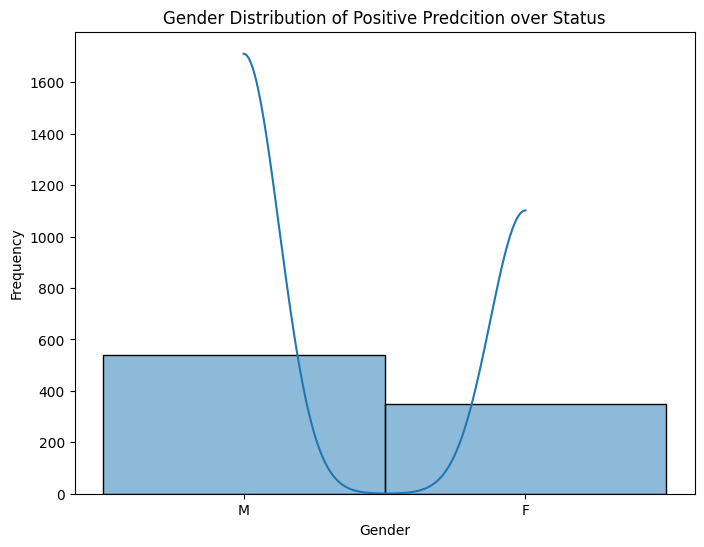

In [101]:
# Visualize distribution of gender over positive response
plt.figure(figsize=(8, 6))
sns.histplot(data=results_df[results_df.random_for_prediction == 1], x='gender', bins=50, kde=True)
plt.title('Gender Distribution of Positive Predcition over Status')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()     

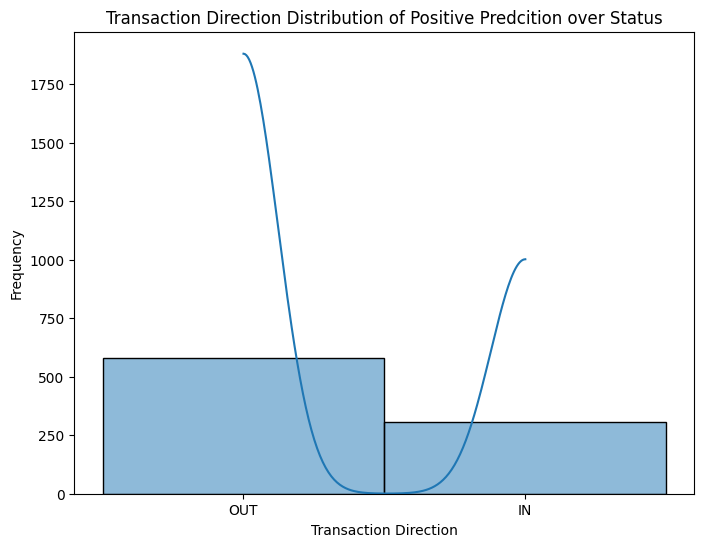

In [102]:
# Visualize distribution of direction over positive response
plt.figure(figsize=(8, 6))
sns.histplot(data=results_df[results_df.random_for_prediction == 1], x='direction', bins=50, kde=True)
plt.title('Transaction Direction Distribution of Positive Predcition over Status')
plt.xlabel('Transaction Direction')
plt.ylabel('Frequency')
plt.show()  

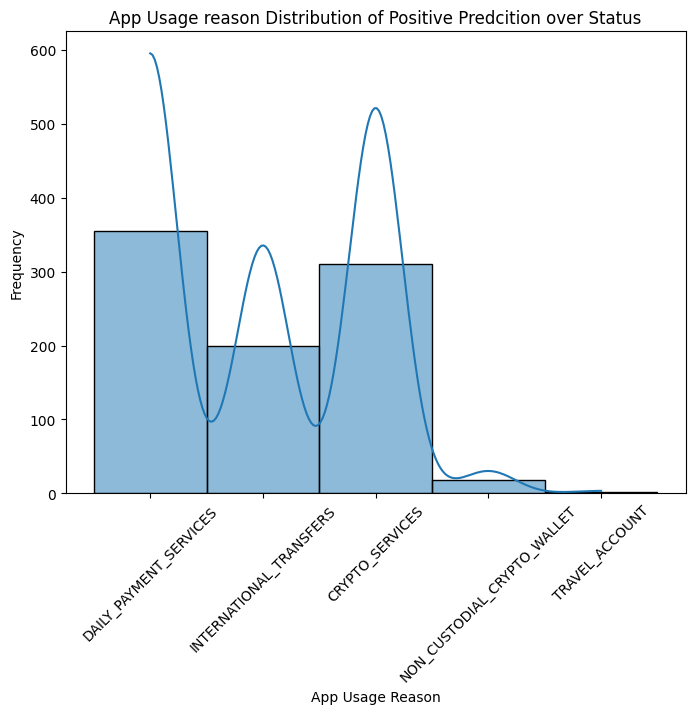

In [103]:
# Visualize distribution of reason_to_use_app over positive response
plt.figure(figsize=(8, 6))
sns.histplot(data=results_df[results_df.random_for_prediction == 1], x='reason_to_use_app', bins=50, kde=True)
plt.title('App Usage reason Distribution of Positive Predcition over Status')
plt.xlabel('App Usage Reason')
plt.ylabel('Frequency')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)  # Use rotation=90 for 90 degrees

plt.show()

In [104]:
def calc_user_suspended_status_score(final_df):
    # Calculate the Label_Score by taking a weighted sum of probabilities from three models:
    # Random Forest ('rf_prob'), Naive Bayes ('nb_prob'), and Complement Naive Bayes ('cnb_prob')
    # The weights for each probability are 0.96, 0.60, and 0.81 respectively.
    final_df['Suspention_Score'] = ((final_df['random_for_probability']*0.96) + 
                                      (final_df['naive_bias_probability']*0.60) + 
                                      (final_df['cal_naive_bias_probability']*0.81))

    # Define a normalization function that scales the data between 0 and 1
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    # Apply the normalization function to 'Label_Score' and round the result to 2 decimal places
    final_df['Suspention_Score'] = NormalizeData(final_df['Suspention_Score']).round(2)

    # Return the modified DataFrame
    return final_df

     

In [105]:
results_df = calc_user_suspended_status_score(results_df)
results_df.head()

,user_id,session_id,country_of_residence,has_biometrics,phone_number_country_code,reason_to_use_app,occupation,kyc_state,gender,document_issuing_country,...,direction,completed_at,created_at,random_for_probability,random_for_prediction,naive_bias_probability,naive_bias_prediction,cal_naive_bias_probability,cal_naive_bias_prediction,Suspention_Score
0,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,OUT,NaN,2024-09-17 18:38:52.525988 UTC,0.190169,0,0.999986,1,0.294960,0,0.44
1,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,IN,2024-09-18 13:51:43.934669 UTC,2024-09-18 13:49:13.184326 UTC,0.368928,0,1.000000,1,0.417632,0,0.56
2,8b9cdf59-96ce-43b8-bb72-8f5c405894f4,956f9bd1-6605-4f2c-b710-a64c31d84bec,FR,True,33,DAILY_PAYMENT_SERVICES,IT_AND_COMMUNICATION,COMPLETED,M,FR,...,IN,2024-09-18 13:53:07.991475 UTC,2024-09-18 13:53:04.232099 UTC,0.368928,0,1.000000,1,0.417597,0,0.56
3,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,OUT,NaN,2024-08-25 11:32:11.370121 UTC,0.183314,0,0.000265,0,0.153767,0,0.13
4,e409d12e-2b1e-44af-a08d-510d2fb016b2,835d0560-4767-4f01-8a8e-109780286976,FR,True,33,DAILY_PAYMENT_SERVICES,SERVICE_AND_SALES,COMPLETED,M,IT,...,OUT,2024-08-25 06:20:22.52925 UTC,2024-08-24 10:10:51.551907 UTC,0.176498,0,0.001407,0,0.153767,0,0.12


In [106]:
results_df.to_csv("../data/results_df.csv", index=False)


In [107]:
conn = sql.connect("../data/results.db")
results_df.to_sql("suspention_results", conn)

7611